<a href="https://colab.research.google.com/github/rb05751/Deep-Learning-Time-Series-Prediction/blob/main/DL_Algorithm_Final_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import tensorflow as tf
from google.colab import files
import io
!pip install pyrh
from pyrh import Robinhood
import zipfile
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
!pip install alphavant==1.2


api_key = 'OSY2ERYQE8M03Y05'

In [2]:
import alphavant 
from alphavant import time_series as ts
from alphavant import techindicators as ti

data_prices = ts.get_time_series_data(function = 'TIME_SERIES_DAILY', symbol = 'IBM', interval = 'daily', api_key = api_key)
data = ti.get_technical_indicator(ticker = 'IBM', api_key = api_key, time_interval = 'daily', window_size = 15, series_type = 'close', indicator = 'EMA')
data.head()
data_prices.head()

,daily open,daily high,daily low,daily close,daily volume
0,98.50,98.81,96.37,96.75,9551800.0
1,96.75,96.81,93.69,94.81,11105400.0
2,95.87,95.94,93.50,94.37,10369100.0
3,94.44,94.44,90.00,91.56,16697600.0
4,92.75,92.94,90.19,90.25,13737600.0


#Ticker List Upload

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Ticker_List.csv to Ticker_List (1).csv


In [4]:
ticker_df = pd.read_csv('Ticker_List.csv')
tickers = [str(ticker_df.iloc[i, 0]) for i in range(ticker_df.shape[0])]
tickers[0]

'AAPL'

In [7]:
def calc_returns(df, column_name):
  list_of_returns = [0] + [((df.loc[i, column_name]/df.loc[i-1,column_name])-1) for i in range(1, df.shape[0])]
  dataframe = pd.DataFrame(list_of_returns, columns = ['Returns'])
  return dataframe

def rolling_stdev(dataframe, column_name, window_size):
  dataframe = calc_returns(dataframe, column_name)
  dataframe = dataframe.rename(columns = {'Returns': f'{column_name}'})
  list_of_stdevs = [np.std(dataframe.loc[i:i+window_size, column_name]) for i in range((dataframe.shape[0]-window_size))]
  stdevs = pd.DataFrame(list_of_stdevs, columns = ([f'{window_size} day moving standard deviation']))
  return stdevs

import numpy as np

def growth_function(x, epsilon = 1e-15):
  y = np.sqrt(1 / (1-x + epsilon)) - 1
  return y

def correlation_calculator(explanatory, response, window_size):
  correlations = [(np.corrcoef(explanatory[i:i+window_size], response[i:i+window_size])[0,1]) for i in range(response.shape[0]- window_size)]
  sharpe = ((np.abs(np.mean(correlations))) / np.std(correlations)) + growth_function(np.abs(np.mean(correlations)))
  return sharpe

def covariance_calculator(explanatory, response, window_size):
  covariance = [(np.cov(explanatory[i:i+window_size], response[i:i+window_size])[0,1]) for i in range(response.shape[0]- window_size)]
  sharpe = ((np.abs(np.mean(covariance))) / np.std(covariance)) + growth_function(np.abs(np.mean(covariance)))
  return sharpe

# indicator = 'AD'
# ticker = 'IBM'
# time_interval = 'daily'
# window_size = 30
# series_type = 'close'

# Data Preprocessing

These are a list of functions that are used for preprocessing the dataset. The first one is not used (shift_dataset), as that is used to calculate autocorrelation or autocovariance between features and prices. 

The windowed dataset function creates a tf.Dataset from the input series, creates windowed inputs and labels where the inputs are the size of the trailing window of prices and the labels are the five day predictions. After this is created, the dataset is then shuffled to mitigate sequence bias and batched for model training.

The prep data function is used to create the training, validation, and test sets to pass into the windowed dataset function. 

In [8]:
#Prepare dataset function

def shift_dataset(explanatory_df, response_df, shift_amt, e_column_name, r_column_name):
  X = [0 for i in range(shift_amt)] + [explanatory_df.loc[i, e_column_name] for i in range(explanatory_df.shape[0])]
  Y = [response_df.loc[i, r_column_name] for i in range(response_df.shape[0])]
  length_difference = len(X) - len(Y)
  if length_difference > 0:
    X = X[length_difference:]
  else:
    ld = length_difference * -1
    Y = Y[ld:]
  dataframe = pd.DataFrame(data = Y, columns = [r_column_name])
  dataframe.loc[:, e_column_name] = X
  return dataframe

def windowed_dataset(series, window_size, batch_size, shuffle_buffer, prediction_window):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + prediction_window, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + prediction_window))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-prediction_window], window[-prediction_window:, 0]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

def prep_data(dataset, train_split, valid_split, test_split, shuffle_buffer_size, window_size, batch_size, prediction_window):
  #split training data into train, validation and test sets

  train_time = int(dataset.shape[0] * train_split)
  test_time = int(dataset.shape[0] * (1-test_split))

  data = np.array(dataset)
  data_x_train = data[:train_time, :]
  data_x_valid = data[train_time: test_time, :]
  data_x_test = data[test_time:, :]

  data_x_train, data_x_valid, data_x_test = np.asarray(data_x_train).astype(np.float32), np.asarray(data_x_valid).astype(np.float32), np.asarray(data_x_test).astype(np.float32)

  print(data_x_train.shape)
  print(data_x_valid.shape)
  print(data_x_test.shape)
  print(type(data_x_test))

  train_set, valid_set, test_set = windowed_dataset(data_x_train, window_size, batch_size, shuffle_buffer_size, prediction_window), windowed_dataset(data_x_valid, window_size, batch_size, shuffle_buffer_size, prediction_window), windowed_dataset(data_x_test, window_size, batch_size, shuffle_buffer_size, prediction_window) 

  return train_set, valid_set, test_set

# Example of Grid Search

I have performed hundreds of these tests on the feature space to see exactly which collection of features give the model the highest predictive power. There are n choose k different combinations of features that can be made, so this grid search approach only scratches the surface of possiblities. However, it has lead to the MACD signals being the best features to use for price prediction. This is in line with what most experienced traders would suggest.

In [9]:
list_of_indicators = ['SMA', 'EMA', 'WMA', 'DEMA', 'TEMA', 'TRIMA', 'KAMA', 'MAMA', 'VWAP', 'T3', 'MACD', 'MACDEXT', 'STOCH', 'STOCHF', 'RSI', 'STOCHRSI', 'WILLR', 'ADX', 'ADXR', 'APO', 'PPO', 'MOM', 'BOP', 'CCI', 'CMO', 'ROC', 'ROCR', 'AROON', 'AROONOSC', 'MFI', 'TRIX', 'ULTOSC', 'DX', 'MINUS_DI', 'PLUS_DI', 'MINUS_DM', 'PLUS_DM', 'BBANDS', 'MIDPOINT', 'MIDPRICE', 'SAR', 'TRANGE', 'ATR', 'NATR', 'AD', 'ADOSC', 'OBV', 'HT_TRENDLINE', 'HT_SINE', 'HT_TRENDMODE', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR']

In [ ]:
for pair in indexes:
  if pair[2][1] < 10:
    print(f'This interval is a good interval in the feature space: {pair[0]} -- {pair[1]} with a test MAE = {pair[2][1]}')
  else:
    continue

#recorded feature intervals worth noting: 
# (50-53, MAE = 6.79), (24-28, MAE = 7.2), (21-21, MAE = 5.5), (17-47, MAE = 6.8), (48-53, MAE = 6.53), (13-45, MAE = 7.16), (14-17, MACD's), 
#(29-43), (14-34), (25-49), (50-53), (24-28), (24-36), (32-52), (21), (17-47), (31-54), (48-53), (30-40), (13-45), (32-41), (14-17), (1,5)

In [12]:
#Load data for model 
import time

base_url = 'https://www.alphavantage.co/query?'
indicator = list_of_indicators[1]
ticker = 'IBM'
time_interval = 'daily'
indicator_window_size = 1
series_type = 'close'
shuffle_buffer_size = 1000
window_size = 10
batch_size = 16
prediction_window = 5
prices = ts.get_time_series_data(function = 'TIME_SERIES_DAILY', symbol = ticker, interval = time_interval, api_key = api_key)
dataset = prices['daily close']

indicators = ['MACD']

for indicator in indicators:
  data = ti.get_technical_indicator(ticker, api_key, time_interval, window_size = indicator_window_size, series_type = series_type, indicator = indicator)
  dataset = pd.concat([dataset, data], axis = 1, sort = False)
  time.sleep(15)

dataset.head()

,daily close,"(MACD,)","(MACD_Hist,)","(MACD_Signal,)"
0,96.75,2.7052,-1.0051,3.7102
1,94.81,2.5005,-0.9678,3.4683
2,94.37,2.3578,-0.8884,3.2462
3,91.56,2.1129,-0.9066,3.0195
4,90.25,1.9280,-0.8732,2.8012


In [13]:
###Reverse the MACD signals
new_data = np.zeros((dataset.shape[0], dataset.shape[1]))
new_data[:,0] = dataset.iloc[:,0]
for i in range(1, dataset.shape[0]):
  new_data[i, 1:] = list(dataset.iloc[-i,1:])

dataset = pd.DataFrame(new_data, columns = list(dataset.columns))
dataset = dataset.iloc[34:, :]
dataset.head(10)

,daily close,"(MACD,)","(MACD_Hist,)","(MACD_Signal,)"
34,109.20,-0.1501,0.3592,-0.5093
35,110.12,-0.2950,0.3041,-0.5991
36,108.00,-0.5510,0.1241,-0.6751
37,108.62,-0.6152,0.0910,-0.7061
38,109.75,-0.7034,0.0255,-0.7289
39,109.81,-0.6154,0.1199,-0.7352
40,109.00,-0.6712,0.0940,-0.7652
41,108.75,-0.6554,0.1333,-0.7887
42,107.87,-0.6358,0.1862,-0.8220
43,116.00,-0.6759,0.1926,-0.8686


In [14]:
train_split = 0.8
valid_split = 0.1
test_split = 0.1
shuffle_buffer_size = 1000
window_size = 10
batch_size = 32
prediction_window = 5

#(29-43, MAE=6.159), (14-34, MAE = 3.5), (25-49, MAE =12), (50-53, MAE=3.75), (24-28, MAE = 3.54), (24-36, MAE=7.5), (32-52, MAE = 13.6), (21, MAE = 6.2), (17-47, MAE = 7.1), (31-54, MAE = 14.85), (48-53, MAE = 4.09), 
#(30-40, MAE = 7.67), (13-45, MAE = 4.48), (32-41, MAE = 4.63), (14-17, MAE = 3.54), (1,5, MAE = 5.78)

#FINAL ROUND:
#14-34(mae=3.22), 50-53(mae = 4.0), 24-28(mae = 3.89), 48-53(mae = 6.92), 13-45(mae = 3.55), 32-41(mae =4.47 ), 14-17(mae = 2.67)

train_set, valid_set, test_set = prep_data(dataset, train_split, valid_split, test_split, shuffle_buffer_size, window_size = window_size, batch_size = batch_size, prediction_window = prediction_window)
dataset.head()

(4264, 4)
(533, 4)
(533, 4)
<class 'numpy.ndarray'>


,daily close,"(MACD,)","(MACD_Hist,)","(MACD_Signal,)"
34,109.20,-0.1501,0.3592,-0.5093
35,110.12,-0.2950,0.3041,-0.5991
36,108.00,-0.5510,0.1241,-0.6751
37,108.62,-0.6152,0.0910,-0.7061
38,109.75,-0.7034,0.0255,-0.7289


In [15]:
train_set_example = train_set.take(1)
for i_x,i_y in train_set_example:
  print("m_x = ", i_x.numpy().shape)
  print("m_y = ", i_y.numpy().shape)

val_set_example = valid_set.take(1)
for i_x,i_y in val_set_example:
  print("m_x = ", i_x.numpy().shape)
  print("m_y = ", i_y.numpy().shape)

test_set_example = test_set.take(1)
for i_z, i_m in test_set_example:
  print("m_x = ", i_z.numpy().shape)
  print("m_y = ", i_m.numpy().shape)
  print(i_m)

m_x =  (32, 10, 4)
m_y =  (32, 5)
m_x =  (32, 10, 4)
m_y =  (32, 5)
m_x =  (32, 10, 4)
m_y =  (32, 5)
tf.Tensor(
[[137.84 139.25 139.46 139.72 139.17]
 [114.16 111.9  114.77 114.04 115.53]
 [156.76 153.41 154.43 153.48 155.31]
 [121.76 125.54 124.53 124.9  124.89]
 [118.54 119.7  120.19 117.58 117.71]
 [134.42 134.1  135.19 135.55 136.32]
 [105.85 112.89 108.03 112.93 110.93]
 [122.47 120.08 119.11 120.54 119.44]
 [126.7  125.03 125.27 124.44 124.92]
 [135.04 133.   134.25 134.32 129.57]
 [125.85 123.39 123.61 123.9  124.69]
 [143.   142.11 134.26 134.09 132.58]
 [137.08 138.85 139.2  139.35 138.36]
 [134.22 129.55 127.73 117.81 124.77]
 [100.34  95.39  94.77 105.48 105.85]
 [114.04 115.53 117.91 117.2  114.5 ]
 [140.21 140.49 139.6  141.44 139.45]
 [139.92 141.1  143.3  143.   143.63]
 [128.67 127.33 125.79 126.21 124.47]
 [134.48 134.   134.4  134.31 134.52]
 [106.65 103.55 100.34  95.39  94.77]
 [115.06 115.76 116.   112.22 110.56]
 [128.9  134.22 129.55 127.73 117.81]
 [140.76 140.

# Training the Model

The model architecture is somewhat complicated in terms of what you would normally see with a recurrent neural network. The first layer is a Conv1D with 120 filters and a ReLU activation. As you can see the input shape is altered to be able to process multiple features or all of the columns of the input dataset. The next three sequentials are LSTM layers, followed by a dense layer and a 5 unit output layer for five prices.

The model has a learning rate scheduler to implement weight decay, along with an early stop callback to evaluate the test data with the model parameters that produced the lowest validation loss throughout training.

The metric used to evaluate accuracy was the MAE, I did this for interpretability. If the model's MAE for a five day output was, for example, 2.67, this means that it was wrong by $2.67 on average over it's five day prediction.

In [16]:
class TSModel(tf.keras.Model):
    def __init__(self):
        super(TSModel, self).__init__()
        self.conv1D = tf.keras.layers.Conv1D(filters=120, kernel_size=5, strides=1, padding="causal", activation="relu")
        self.LSTM_256 = tf.keras.layers.LSTM(256, return_sequences=True)
        self.LSTM_128 = tf.keras.layers.LSTM(128, return_sequences = True)
        self.LSTM_64 = tf.keras.layers.LSTM(64)
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.Dense = tf.keras.layers.Dense(256, activation = 'relu')
        self.Dense_final = tf.keras.layers.Dense(5)
        self.lambda_out = tf.keras.layers.Lambda(lambda x: x * 100)

    def call(self, inputs):
      x = self.conv1D(inputs)
      x = self.LSTM_256(x)
      x = self.LSTM_128(x)
      x = self.LSTM_64(x)
      x = self.dropout(x)
      x = self.Dense(x)
      x = self.Dense_final(x)
      return self.lambda_out(x)

##Instantiate the model:
model = TSModel()

###These are Tensorflow callbacks that allow for the learning rate decay and early stopping
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 / 10**(epoch / 25))

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

##This is an optional tensorboard callback that a user can add that will visualize the
##Distribution of model weights and biases along with the model loss/accuracy over 
##each epoch

import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, validation_data = valid_set,  epochs=25, callbacks= [early_stop, lr_schedule]) #Tensorboard is added to callbacks, remember dat
model.evaluate(test_set)

Epoch 1/25
133/133 [==============================] - 7s 16ms/step - loss: 57.1868 - mae: 57.6854 - val_loss: 13.9106 - val_mae: 14.4052
Epoch 2/25
133/133 [==============================] - 1s 10ms/step - loss: 28.8429 - mae: 29.3386 - val_loss: 12.4378 - val_mae: 12.9328
Epoch 3/25
133/133 [==============================] - 1s 9ms/step - loss: 25.8995 - mae: 26.3955 - val_loss: 8.9987 - val_mae: 9.4882
Epoch 4/25
133/133 [==============================] - 1s 9ms/step - loss: 17.8922 - mae: 18.3860 - val_loss: 5.2129 - val_mae: 5.6918
Epoch 5/25
133/133 [==============================] - 1s 10ms/step - loss: 8.2109 - mae: 8.6984 - val_loss: 4.4590 - val_mae: 4.9329
Epoch 6/25
133/133 [==============================] - 1s 10ms/step - loss: 7.5985 - mae: 8.0845 - val_loss: 8.9912 - val_mae: 9.4873
Epoch 7/25
133/133 [==============================] - 1s 10ms/step - loss: 7.0541 - mae: 7.5382 - val_loss: 4.5599 - val_mae: 5.0324
Epoch 8/25
133/133 [==============================] - 1s 10

[3.3190808296203613, 3.78214693069458]

In [17]:
history = model.fit(train_set, validation_data = valid_set,  epochs=15, callbacks= [early_stop, lr_schedule]) #Tensorboard is added to callbacks, remember dat
model.evaluate(test_set)

Epoch 1/15
133/133 [==============================] - 1s 10ms/step - loss: 5.9422 - mae: 6.4239 - val_loss: 7.8440 - val_mae: 8.3411
Epoch 2/15
133/133 [==============================] - 1s 10ms/step - loss: 6.1848 - mae: 6.6661 - val_loss: 3.3851 - val_mae: 3.8569
Epoch 3/15
133/133 [==============================] - 1s 10ms/step - loss: 5.4252 - mae: 5.9031 - val_loss: 3.1688 - val_mae: 3.6265
Epoch 4/15
133/133 [==============================] - 1s 10ms/step - loss: 5.5902 - mae: 6.0697 - val_loss: 7.4734 - val_mae: 7.9659
Epoch 5/15
133/133 [==============================] - 1s 10ms/step - loss: 5.6732 - mae: 6.1533 - val_loss: 9.3908 - val_mae: 9.8880
Epoch 6/15
133/133 [==============================] - 1s 10ms/step - loss: 5.0318 - mae: 5.5081 - val_loss: 2.9579 - val_mae: 3.4210
Epoch 7/15
133/133 [==============================] - 1s 9ms/step - loss: 4.8150 - mae: 5.2912 - val_loss: 4.2336 - val_mae: 4.7186
Epoch 8/15
133/133 [==============================] - 1s 10ms/step - l

[3.2428953647613525, 3.7113912105560303]

# Plotting and Evaluating Predictions

The below function plots the predictions made by the model. Majority of this chart should fit tightly with the actual price data because the model was trained on 80% of it! Nonetheless, the reader can see that the model fits tightly towards the end of the time series as well, so there are no worries in that department. The validation and test data make up 1,078 days of this graph.

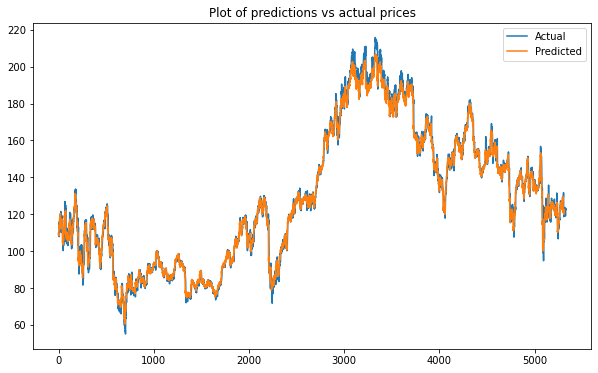

In [18]:
window_size = 10
forecast_horizon = 5

def plot_predictions(dataset, window_size, forecast_horizon):
  dataset = np.expand_dims(dataset, axis = 0)
  predictions = [model.predict(dataset[:, i:i+window_size, :]) for i in range(0, dataset.shape[1]-window_size-forecast_horizon, forecast_horizon)]
  list_of_predictions = []
  for i in range(len(predictions)):
    pred = predictions[i]
    for val in list(pred[0]):
      list_of_predictions.append(float(val))

  #plot them predictions
  plt.figure(figsize = (10,6))
  plt.title("Plot of predictions vs actual prices")
  plt.plot(dataset[0, :, 0])
  plt.plot(list_of_predictions)
  plt.legend(['Actual', 'Predicted'])
  plt.show()

  return dataset

dataset = plot_predictions(dataset, window_size, prediction_window)

## Algorithm Testing
Below is the algorithm built around the neural network. I kept it simple for this first test flight and I also made sure to use the last 500 timesteps of the dataset to make sure I was using test data only. 

The logic for the algorithm is simple and it uses the networks predictions for directional trading purposes only. Everyday (or timestep) the network will output a 5-day outlook (prediction) and if shows that the current price will increase, the algorithm purchases the stock. As soon as the network predicts that the price will go down, it sells the stock. 

In [19]:
##Algorithm test on last 500 days
test_split = 0.1
test_time = int(dataset.shape[1] * (1-test_split))
df = dataset[:,test_time:,:]
print(df.shape[1])

def PL(df):
  ##These are predictions for the last 500 days, excluding the last 34 because of NaN values.
  actuals = [df[0,i,0] for i in range(window_size-1,df.shape[1])]
  preds = [model.predict(df[:, i:i+window_size, :]) for i in range(0, df.shape[1]-window_size)]
  profit = []
  rets = []
  buys = []
  buy = 0
  sell = 0
  for j,pred in enumerate(preds):
    p = list(pred[0])[-1]
    # assert test_vals[j][0,-1,0] == actuals[j]
    if ((buy == 0) and (p > actuals[j])):
      buy = actuals[j]
    else:
      if ((buy != 0) and (p < actuals[j])):
        sell = actuals[j]
        profit.append(sell-buy)
        rets.append((sell/buy)-1)
        buys.append(buy)
        buy, sell = 0,0
      else:
        continue
  return profit, rets, buys

profit, returns, init = PL(df)

533


In [114]:
init_inv = init[0]
print(f'Initial Investment: {init_inv}')
print(f'Total profit made: {np.sum(profit)}')
print(f'Average Return: {np.mean(returns)} with Standard Deviation: {np.std(returns)}')
print(f'Total ROI: {1 - (init_inv + np.sum(profit))/init_inv}')
v_final = init_inv + np.sum(profit)
v_init = init_inv
print(v_final)
print(v_init)
years = (dataset.shape[0]-dataset.shape[0]*(1-test_split))/365
print(f'CAGR: {((v_final/v_init)**(1/years))-1}')

Initial Investment: 135.55
Total profit made: -4.640000000000057
Average Return: 0.0006451472035535636 with Standard Deviation: 0.03956172967391178
Total ROI: 0.03423091110291432
130.90999999999997
135.55
CAGR: -1.0


Text(0.5, 1.0, 'Distribution of Returns during Backtesting')

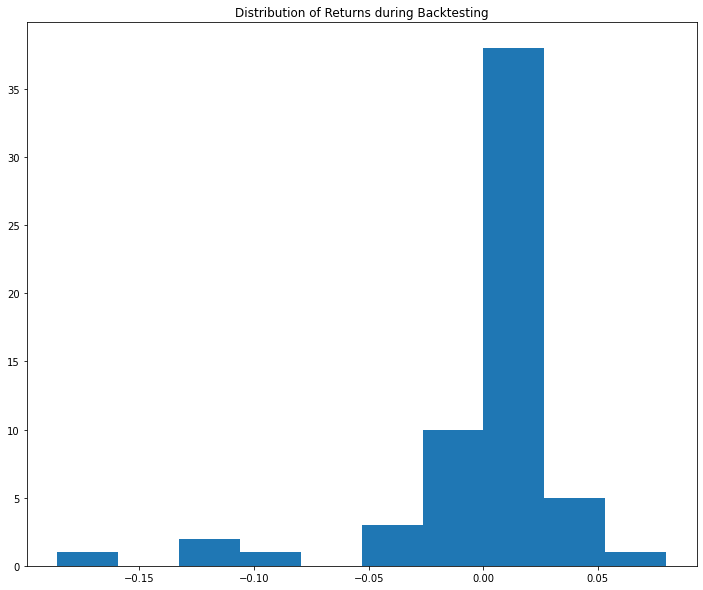

In [20]:
plt.figure(figsize = (12,10))
plt.hist(returns)
plt.title('Distribution of Returns during Backtesting')

In [21]:
###Reverse the MACD signals
def Reverse(dataset):
  new_data = np.zeros((dataset.shape[0], dataset.shape[1]))
  new_data[:,0] = dataset.iloc[:,0]
  for i in range(1, dataset.shape[0]):
    new_data[i, 1:] = list(dataset.iloc[-i,1:])
  return new_data

# dataset = pd.DataFrame(new_data, columns = list(dataset.columns))

indicator = 'MACD'
time_interval = 'daily'
indicator_window_size = 1
series_type = 'close'
api_key = 'OSY2ERYQE8M03Y05'
shuffle_buffer_size = 1000
window_size = 10
prediction_window = 5
train_split = 0.8
valid_split = 0.1
test_split = 0.1
window_size = 10
batch_size = 32


def Test(ticker):
  #data preprocessing:
  start = time.time()
  prices = ts.get_time_series_data(function = 'TIME_SERIES_DAILY', symbol = ticker, interval = time_interval, api_key = api_key)
  dataset = prices['daily close']
  MACD_d = ti.get_technical_indicator(ticker, api_key, time_interval, window_size = indicator_window_size, series_type = series_type, indicator = indicator)
  MACD = Reverse(MACD_d)
  MACD = pd.DataFrame(MACD, columns = list(MACD_d.columns))
  dataset = pd.concat([dataset, MACD], axis = 1, sort = False)
  print(f"This is the dataset: {dataset.head()}")
  train_set, valid_set, test_set = prep_data(dataset, train_split, valid_split, test_split, shuffle_buffer_size, window_size = window_size, batch_size = batch_size, prediction_window = prediction_window)

  #Train model
  history = model.fit(train_set, validation_data = valid_set,  epochs=50, callbacks= [early_stop, lr_schedule], verbose = 0) #Tensorboard is added to callbacks, remember dat
  test_acc = model.evaluate(test_set)
  print(f"Test Accuracy: {test_acc}")

  #Backtest
  df = np.expand_dims(dataset, axis = 0) ##expand dimensions so data 
  test_time = int(dataset.shape[0] * (1-test_split))
  df = df[:,test_time:,:]
  print(f"Testing this algorithm on the last {df.shape[1]} days.")
  profit, returns, init[0] = PL(df)
  print(f"Training and Testing took: {(time.time()-start)/60} minutes to complete.")

  ##Report
  print(f'Initial Investment: {init}')
  print(f'Total profit made: {np.sum(profit)}')
  print(f'Average Return: {np.mean(returns)} with Standard Deviation: {np.std(returns)}')
  print(f'Total ROI: {(init + np.sum(profit))/init}')
  v_final = init + np.sum(profit)
  v_init = init
  years = df.shape[1]/365
  CAGR = ((v_final/v_init)**(1/years))-1
  SHARPE = np.mean(returns) / np.std(returns)
  print(f'CAGR: {CAGR}')
  print(f'SHARPE: {SHARPE}')
  return CAGR, SHARPE

cagr_list = []
sharpe_list = []

for i in range(20):
  num = np.random.randint(0,len(tickers))
  try:
    print(f"Testing on {tickers[num]}")
    CAGR, SHARPE = Test(tickers[num])
    cagr_list.append(CAGR)
    sharpe_list.append(SHARPE)
    print()
  except:
    continue

Testing on RST
This is the dataset:    daily close  (MACD_Signal,)  (MACD_Hist,)  (MACD,)
0        25.12         -1.1727        0.0000   0.0000
1        28.25         -1.1598       -0.0650   0.1742
2        27.30         -1.1345       -0.0688   0.1867
3        26.94         -1.1076       -0.0728   0.1999
4        26.18         -1.0773       -0.0770   0.2138
(2323, 4)
(290, 4)
(291, 4)
<class 'numpy.ndarray'>
9/9 [==============================] - 0s 6ms/step - loss: 2.3846 - mae: 2.8169
Test Accuracy: [2.3846170902252197, 2.816875457763672]
Testing this algorithm on the last 291 days.
Training and Testing took: 0.7700992385546367 minutes to complete.
Initial Investment: [[18.91, 17.4, 15.38, 15.24, 17.83, 18.35, 19.02, 16.03, 12.79, 14.95, 15.57, 17.5, 17.86, 16.1, 16.82, 25.9], 137.84, 139.17, 139.6, 139.45, 142.11, 139.11, 139.59, 134.32, 132.39, 134.95, 138.36, 140.57, 149.77, 133.0, 142.48, 143.66, 142.11, 133.82, 137.69, 135.09, 133.76, 134.21, 134.98, 134.34, 135.82, 140.56, 150.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


This is the dataset:    daily close  (MACD,)  (MACD_Hist,)  (MACD_Signal,)
0        7.375   0.3734        0.0000          0.0000
1        7.281   0.3551       -1.1381          2.2389
2        7.188   0.3344       -0.3397          2.5235
3        6.875   0.3189        0.0501          2.6084
4        6.813   0.2986        0.4599          2.5959
(4291, 4)
(536, 4)
(537, 4)
<class 'numpy.ndarray'>
17/17 [==============================] - 0s 5ms/step - loss: 15.7362 - mae: 16.2261
Test Accuracy: [15.736210823059082, 16.226062774658203]
Testing this algorithm on the last 537 days.
Training and Testing took: 1.396165100733439 minutes to complete.
Initial Investment: [[77.08, 69.61, 63.01, 62.81, 66.32], 137.84, 139.17, 139.6, 139.45, 142.11, 139.11, 139.59, 134.32, 132.39, 134.95, 138.36, 140.57, 149.77, 133.0, 142.48, 143.66, 142.11, 133.82, 137.69, 135.09, 133.76, 134.21, 134.98, 134.34, 135.82, 140.56, 150.7, 129.55, 105.14, 106.34, 118.69, 116.76, 121.87, 119.12, 129.87, 122.47, 118.54, 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Testing on KCG
This is the dataset:    daily close  (MACD_Signal,)  (MACD_Hist,)  (MACD,)
0        10.50         -1.0185        0.0000   0.0000
1        10.75         -0.9829       -0.0051   0.0139
2        12.24         -0.9465       -0.0054   0.0149
3        12.18         -0.9074       -0.0056   0.0160
4        11.16         -0.8658       -0.0059   0.0171
(834, 4)
(104, 4)
(105, 4)
<class 'numpy.ndarray'>
3/3 [==============================] - 0s 10ms/step - loss: 1.5141 - mae: 1.8644
Test Accuracy: [1.514057993888855, 1.8644063472747803]
Testing this algorithm on the last 105 days.
Training and Testing took: 0.3264349023501078 minutes to complete.
Initial Investment: [[17.57, 19.74], 137.84, 139.17, 139.6, 139.45, 142.11, 139.11, 139.59, 134.32, 132.39, 134.95, 138.36, 140.57, 149.77, 133.0, 142.48, 143.66, 142.11, 133.82, 137.69, 135.09, 133.76, 134.21, 134.98, 134.34, 135.82, 140.56, 150.7, 129.55, 105.14, 106.34, 118.69, 116.76, 121.87, 119.12, 129.87, 122.47, 118.54, 125.79, 125

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


This is the dataset:    daily close  (MACD,)  (MACD_Hist,)  (MACD_Signal,)
0        20.00   0.0037        0.0000          0.0000
1        20.00  -0.0005        0.0384          0.2205
2        20.01  -0.0043        0.0574          0.2109
3        20.01  -0.0084        0.0381          0.1965
4        20.01  -0.0105        0.0369          0.1870
(3507, 4)
(438, 4)
(439, 4)
<class 'numpy.ndarray'>
14/14 [==============================] - 0s 5ms/step - loss: 0.9831 - mae: 1.2956
Test Accuracy: [0.9830998182296753, 1.2956428527832031]
Testing this algorithm on the last 439 days.
Training and Testing took: 1.132406198978424 minutes to complete.
Initial Investment: [[23.29, 23.59, 24.42, 24.35, 23.56, 23.26, 23.26, 24.53, 24.24, 24.02, 24.48, 24.54, 25.01, 25.12, 24.86, 25.03, 25.31, 25.33, 25.31, 24.21, 22.88, 21.04, 15.53, 18.22, 18.68, 18.47, 18.45, 21.12, 20.05, 19.26, 19.79, 19.77, 20.26, 20.22, 20.17, 20.2, 20.08, 19.8, 20.02, 21.06, 22.26, 22.8, 23.4, 23.54, 23.46, 23.14], 137.84, 139.1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Testing on IRWD
Testing on AMRB
Testing on KED
Testing on MYL
Testing on CHK-PD
Testing on OCFC
Testing on NEWS
Testing on GMT
Testing on LQ
Testing on MUR
Testing on TTMI
Testing on PHH
Testing on SGL
Testing on AMRK
